# 模型选择、欠拟合和过拟合
将模型在训练数据上拟合的比在潜在分布中更接近的现象称为*过拟合*（overfitting），用于对抗过拟合的技术称为*正则化*（regularization）。

## 训练误差和泛化误差
*训练误差*（training error）是指，模型在训练数据集上计算得到的误差。  
*泛化误差*（generalization error）是指，模型应用在同样从原始样本的分布中抽取的无限多数据样本时，模型误差的期望。

### 模型复杂性
重点介绍几个倾向于影响模型泛化的因素。

1. 可调整参数的数量。当可调整参数的数量（有时称为*自由度*）很大时，模型往往更容易过拟合。
1. 参数采用的值。当权重的取值范围较大时，模型可能更容易过拟合。
1. 训练样本的数量。即使模型很简单，也很容易过拟合只包含一两个样本的数据集。而过拟合一个有数百万个样本的数据集则需要一个极其灵活的模型。

## 模型选择

在机器学习中，我们通常在评估几个候选模型后选择最终的模型。这个过程叫做*模型选择*。  
有时，需要进行比较的模型在本质上是完全不同的（比如，决策树与线性模型）。又有时，我们需要比较不同的超参数设置下的同一类模型。  
为了确定候选模型中的最佳模型，我们通常会使用验证集。

### 验证集

原则上，在确定所有的超参数之前，不希望用到测试集。
如果在模型选择过程中使用测试数据，可能会有过拟合测试数据的风险。
如果我们过拟合了训练数据，还可以在测试数据上的评估来判断过拟合。但是如果我们过拟合了测试数据，我们又该怎么知道呢？  
因此，决不能依靠测试数据进行模型选择。然而，也不能仅仅依靠训练数据来选择模型，因为我们无法估计训练数据的泛化误差。  
解决此问题的常见做法是将我们的数据分成三份，
除了训练和测试数据集之外，还增加一个*验证数据集*（validation dataset）。  
除非另有明确说明，否则在这本书的实验中，我们实际上是在使用应该被正确地称为训练数据和验证数据的数据集，并没有真正的测试数据集。  

### $K$折交叉验证

当训练数据稀缺时，可能无法提供足够的数据来构成一个合适的验证集。
这里，原始训练数据被分成$K$个不重叠的子集。
然后执行$K$次模型训练和验证，每次在$K-1$个子集上进行训练，
并在剩余的一个子集（在该轮中没有用于训练的子集）上进行验证。
最后，通过对$K$次实验的结果取平均来估计训练和验证误差。

## 欠拟合还是过拟合？

当我们比较训练和验证误差时，我们要注意两种常见的情况。  
1.*欠拟合*（underfitting）：训练误差和验证误差都很严重，但它们之间仅有一点差距。  
如果模型不能降低训练误差，这可能意味着模型过于简单（即表达能力不足），无法捕获试图学习的模式。此外，由于训练和验证误差之间的*泛化误差*很小，我们有理由相信可以用一个更复杂的模型降低训练误差。

2.*过拟合*（overfitting）：训练误差明显低于验证误差。
注意，*过拟合*并不总是一件坏事，众所周知，最好的预测模型在训练数据上的表现往往比在保留（验证）数据上好得多。最终，我们通常更关心验证误差，而不是训练误差和验证误差之间的差距。  

是否过拟合或欠拟合可能取决于模型复杂性和可用训练数据集的大小，  

### 模型复杂性

给定由单个特征$x$和对应实数标签$y$组成的训练数据，我们试图找到下面的$d$阶多项式来估计标签$y$。

$$\hat{y}= \sum_{i=0}^d x^i w_i$$

这只是一个线性回归问题，我们的特征是$x$的幂给出的，
模型的权重是$w_i$给出的，偏置是$w_0$给出的
（因为对于所有的$x$都有$x^0 = 1$）。
由于这只是一个线性回归问题，我们可以使用平方误差作为我们的损失函数。

高阶多项式函数比低阶多项式函数复杂得多。
高阶多项式的参数较多，模型函数的选择范围较广。
因此在固定训练数据集的情况下，
高阶多项式函数相对于低阶多项式的训练误差应该始终更低（最坏也是相等）。
事实上，当数据样本包含了$x$的不同值时，
函数阶数等于数据样本数量的多项式函数可以完美拟合训练集。
在 :numref:`fig_capacity_vs_error`中，
我们直观地描述了多项式的阶数和欠拟合与过拟合之间的关系。


![模型复杂度对欠拟合和过拟合的影响](../img/capacity-vs-error.svg)

### 数据集大小

另一个重要因素是数据集的大小。训练数据集中的样本越少，我们就越有可能（且更严重地）过拟合。随着训练数据量的增加，泛化误差通常会减小。  
给出更多的数据，我们可能会尝试拟合一个更复杂的模型。如果没有足够的数据，简单的模型可能更有用。  
对于许多任务，深度学习只有在有数千个训练样本时才优于线性模型。

## 多项式回归

**通过多项式拟合来探索这些概念**

In [1]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

### 生成数据集

给定$x$，我们将[**使用以下三阶多项式来生成训练和测试数据的标签：**]

**$$y = 5 + 1.2x - 3.4\frac{x^2}{2!} + 5.6 \frac{x^3}{3!} + \epsilon \text{ where }
\epsilon \sim \mathcal{N}(0, 0.1^2).$$**

噪声项$\epsilon$服从均值为0且标准差为0.1的正态分布。

In [2]:
max_degree = 20  # 多项式的最大阶数
n_train, n_test = 100, 100  # 训练和测试数据集大小
true_w = np.zeros(max_degree)  # 分配大量的空间
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)  # gamma(n)=(n-1)!
# labels的维度:(n_train+n_test,)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

In [3]:
# NumPy ndarray转换为tensor
true_w, features, poly_features, labels = [torch.tensor(x, dtype=torch.float32) 
                                           for x in [true_w, features, poly_features, labels]]

In [4]:
features[:2], poly_features[:2, :], labels[:2]

(tensor([[1.5049],
         [0.2963]]),
 tensor([[1.0000e+00, 1.5049e+00, 1.1324e+00, 5.6807e-01, 2.1372e-01, 6.4328e-02,
          1.6135e-02, 3.4688e-03, 6.5255e-04, 1.0912e-04, 1.6421e-05, 2.2466e-06,
          2.8175e-07, 3.2616e-08, 3.5061e-09, 3.5176e-10, 3.3086e-11, 2.9290e-12,
          2.4488e-13, 1.9396e-14],
         [1.0000e+00, 2.9632e-01, 4.3904e-02, 4.3366e-03, 3.2126e-04, 1.9039e-05,
          9.4031e-07, 3.9805e-08, 1.4744e-09, 4.8544e-11, 1.4385e-12, 3.8751e-14,
          9.5690e-16, 2.1812e-17, 4.6167e-19, 9.1202e-21, 1.6891e-22, 2.9442e-24,
          4.8469e-26, 7.5592e-28]]),
 tensor([6.1193, 5.2264]))

### 对模型进行训练和测试

首先让我们[**实现一个函数来评估模型在给定数据集上的损失**]。

In [5]:
def evaluate_loss(net, data_iter, loss):  #@save
    """评估给定数据集上模型的损失"""
    metric = d2l.Accumulator(2)  # 损失的总和,样本数量
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

现在[**定义训练函数**]。

In [6]:
def train(train_features, test_features, train_labels, test_labels, num_epochs=400):
    loss = nn.MSELoss(reduction='none')
    input_shape = train_features.shape[-1]
    # 不设置偏置，因为我们已经在多项式中实现了它
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1,1)), batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1,1)), batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

### [**三阶多项式函数拟合(正常)**]

我们将首先使用三阶多项式函数，它与数据生成函数的阶数相同。
结果表明，该模型能有效降低训练损失和测试损失。
学习到的模型参数也接近真实值$w = [5, 1.2, -3.4, 5.6]$。

weight: [[ 4.9994583  1.2275001 -3.4206939  5.589367 ]]


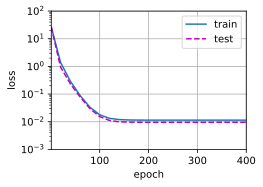

In [10]:
# 从多项式特征中选择前4个维度，即1,x,x^2/2!,x^3/3!
train(poly_features[:n_train, :4], poly_features[n_train:, :4],labels[:n_train], labels[n_train:])

### [**线性函数拟合(欠拟合)**]

让我们再看看线性函数拟合，减少该模型的训练损失相对困难。
在最后一个迭代周期完成后，训练损失仍然很高。
当用来拟合非线性模式（如这里的三阶多项式函数）时，线性模型容易欠拟合。

weight: [[3.6223767 3.9635665]]


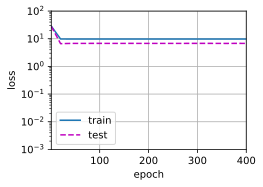

In [8]:
# 从多项式特征中选择前2个维度，即1和x
train(poly_features[:n_train, :2], poly_features[n_train:, :2],labels[:n_train], labels[n_train:])

### [**高阶多项式函数拟合(过拟合)**]

现在，让我们尝试使用一个阶数过高的多项式来训练模型。
在这种情况下，没有足够的数据用于学到高阶系数应该具有接近于零的值。
因此，这个过于复杂的模型会轻易受到训练数据中噪声的影响。
虽然训练损失可以有效地降低，但测试损失仍然很高。
结果表明，复杂模型对数据造成了过拟合。

weight: [[ 4.9884896   1.3250221  -3.3506622   5.132659   -0.19404683  0.95930076
   0.01210203  0.10569113  0.05398435  0.12784216  0.05458954 -0.02695701
  -0.10545219 -0.0880858   0.02312593  0.03022705 -0.19254713 -0.19616188
  -0.1832825   0.17844239]]


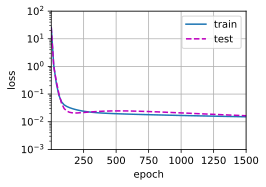

In [9]:
# 从多项式特征中选取所有维度
train(poly_features[:n_train, :], poly_features[n_train:, :], labels[:n_train], labels[n_train:], num_epochs=1500)